In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import xarray as xr
import pandas as pd

In [55]:
name = 'MERRA2_200.tavg1_2d_slv_Nx.20000101.nc4.nc4'
ds = xr.open_dataset('~/research/climate_data/MERRA2/'+name)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 24, lat: 3, lon: 3)
Coordinates:
  * lat      (lat) float64 63.0 63.5 64.0
  * lon      (lon) float64 -146.2 -145.6 -145.0
  * time     (time) datetime64[ns] 2000-01-01T00:30:00 ... 2000-01-01T23:30:00
Data variables:
    U2M      (time, lat, lon) float32 ...
    T2M      (time, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    V2M      (time, lat, lon) float32 ...
    QV2M     (time, lat, lon) float32 ...
Attributes: (12/32)
    History:                           Original file generated: Mon Jan  5 06...
    Comment:                           GMAO filename: d5124_m2_jan91.tavg1_2d...
    Filename:                          MERRA2_200.tavg1_2d_slv_Nx.20000101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    RangeBeginningDate:                20

In [4]:
# GULKANA ELEVATIONS: SITE D 1854 m, SITE B 1693 m, SITE AB 1546 m
glac_no = '01_00570'
initfp = '~/research/PyGEM-EB/pygem_eb/sample_init_data/01_00570.nc'
with xr.open_dataset(initfp.replace('01_00570',glac_no)) as dataset:
    ds = dataset.load()
    # ds = ds.assign_coords({'bin_elev': np.array([2965.5,2911.3,3353.3])})
    # ds.to_netcdf(initfp)
    ds['snow_depth'].values = np.array([2.2,3.3,4])
    # ds['snow_temp'].values = np.array([-1.553,-1.781,-1.931,-3.611,-4.385,-4.635,-4.557,-4.189,-3.244,-3.314,-0.126,-2.189,-2.377,-2.376,-2,-3,-5,-4.8,-4.3,-3.1,-4,-3,-2.8,-2.6,-2.5,0,0])
    tempdata = np.array([-6.635,-8.5,-8.5,-7.833,-7,-6,-5,-4.5,-3.5,-3,0])
    depthdata = np.array([.1,.4,.8,1.2,1.6,2,2.4,2.8,3.2,3.5,30])
    temps = np.interp(ds.layer_depth.to_numpy(),depthdata,tempdata)
    print(ds.snow_density)
# ds.to_netcdf(initfp)

    # print(ds['snow_depth'].values)

<xarray.DataArray 'snow_density' (layer_depth: 27)>
array([390.        , 453.33333333, 542.5       , 600.        ,
       600.        , 600.        , 600.        , 600.        ,
       600.        , 600.        , 600.        , 600.        ,
       600.        , 600.        , 600.        , 600.        ,
       600.        , 600.        , 600.        , 600.        ,
       600.        , 600.        , 600.        , 600.        ,
       600.        , 600.        , 600.        ])
Coordinates:
  * layer_depth  (layer_depth) int64 1 2 3 4 5 6 7 ... 50 60 100 150 200 250 300


In [7]:
import numpy as np
tempdata = np.array([-9.0625,-9,-8,-7.875,-7,-6,-5,-4.5,-3.5,-3.5,0,0])
tempdepth = np.array([.1,.4,.8,1.2,1.6,2,2.4,2.8,3.2,3.5,30,300])
densitydata = np.array([125,155,175,150,220,280,340,365,365,390,400,395,420,410,400,410,470,400,405,420,425,385,390,435,485,485,475,485,470,440,470,455,485,575,600])
densitydepth = np.array([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,500])/100
temp = pd.DataFrame(data={'depth':tempdepth,'temp':tempdata})
density = pd.DataFrame(data={'depth':densitydepth,'density':densitydata})
temp.to_csv('~/research/PyGEM-EB/pygem_eb/sample_init_data/gulkanaBtemp.csv')
density.to_csv('~/research/PyGEM-EB/pygem_eb/sample_init_data/gulkanaBdensity.csv')

In [4]:
def getIrrWaterCont(density,lh):
        """
        Calculates the irreducible water content of the layers.
        """
        density = density.astype(float)
        density_ice = 900
        ice_idx = np.array([8,9,10,11,12,13])

        porosity = (density_ice - density[:ice_idx[0]])/density_ice
        irrwaterfrac = 0.0143*np.exp(3.3*porosity)
        irrwatersat = irrwaterfrac*density[:ice_idx[0]]/porosity # kg m-3, mass of liquid over pore volume
        irrwatercont = irrwatersat*lh[:ice_idx[0]] # kg m-2, mass of liquid in a layer

        irrwatercont = np.append(irrwatercont,np.zeros_like(ice_idx)) # ice layers cannot hold water
        return irrwatercont

In [23]:
lw = np.zeros(8)
density_water = 1000
density_ice = 900
dt = 3600
lh = np.array([0.03,.05677,.09960,.18148,.330695,.602566,1.0979,.903035])
ldm = np.array([3.75,6.83,13.48,30.85,78.92,234.66,441.81,431.40])
ldensity = ldm / lh
irrwatercont = getIrrWaterCont(ldensity,lh)
# layermelt = np.array([0.01,0.005,0.002,0.001,0.0005,0,0,0])
layermelt = np.zeros_like(lh)


rainfall = np.array([0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,2,2.5,2,1,0,1,1,1,1,1,1,1,2,3,1]) / 3600 # kg m-2 s-1
print(len(rainfall))
Sr = 0.033

theta_ice = ldm / (lh*density_ice)
theta_liq = lw / (lh*density_water)
porosity = 1 - theta_ice
lBC = np.zeros_like(theta_ice)
lBC[0] = 0.00001
ldust = lBC.copy()
Ddust = np.zeros_like(ldm)
DBC = np.zeros_like(ldm)
Ddust[0] = 0.000001
DBC[0] = 0.00002
rainBC = 0.05
raindust = 0.01
ksp_dust = 0.015
ksp_BC = 0.1
qi = 0

30


In [28]:
time = np.arange(30)
print('minimum',Sr*porosity*lh*density_water)
for i in time:
    # add rain water to uppermost bin
    lw[0] += rainfall[i]*3600
    # calculate volumetric fractions
    theta_liq = lw / (lh*density_water)
    theta_ice = ldm / (lh*density_ice)
    porosity = 1 - theta_ice

    # initialize flow into the top layer
    qi = 0
    q_in_store = []
    q_out_store = []
    for layer,melt in enumerate(layermelt):
        # set flow in equal to flow out of the previous layer
        q_in = qi
        lw[layer] += melt

        # calculate flow out of layer i (cannot be negative)
        flow_out = density_water*lh[layer]/dt * (theta_liq[layer] - Sr*porosity[layer])
        qi = max(0,flow_out)

        # check limit of qi based on underlying layer holding capacity
        if layer < len(porosity) - 1:
            if porosity[layer] < 0.05 or porosity[layer+1] < 0.05:
                lim = 0
            else:
                lim = density_water*lh[layer+1]/dt * (1-theta_ice[layer+1]-theta_liq[layer+1])
                lim = max(0,lim)
        else: # no limit on bottom layer (1e5 sufficiently high)
            lim = 1e5
        q_out = min(qi,lim)
        # layer water mass balance
        lw[layer] += (q_in - q_out)*dt
        q_in_store.append(q_in)
        q_out_store.append(q_out)
    runoff = q_out
    print(lw,runoff,rainfall[i])

    cBC = lBC/(lw+ldm)
    cdust = ldust/(lw+ldm)
    q_in = np.array(q_in_store)
    q_out = np.array(q_out_store)
    # layer LAP mass balance 
    m_bc_in = ksp_BC*q_out[:-1]*cBC[:-1]
    m_dust_in = ksp_dust*q_out[:-1]*cdust[:-1]
    m_bc_in = np.append(ksp_BC*rainfall[i]*dt*rainBC,m_bc_in)
    m_dust_in = np.append(ksp_dust*rainfall[i]*dt*raindust,m_dust_in)
    m_bc_out = ksp_BC*q_out*cBC
    m_dust_out = ksp_dust*q_out*cdust
    dmBC = (m_bc_in - m_bc_out + DBC)*dt
    lBC += (m_bc_in - m_bc_out + DBC)*dt
    ldust += (m_dust_in - m_dust_out + Ddust)*dt

    # print('water content',lwater)
    # print('minimum',Sr*porosity*lheight*density_water)
    # print('BC',lBC)
    # print('---------------------------')
    # print('Sum of layer water',np.sum(lwater))
    # print('Rainfall',rainfall[i]*3600)

minimum [ 0.8525      1.62297667  2.79253333  4.85767333  8.01920167 11.280478
 20.031      13.982155  ]
[ 0.8525      1.62297667  3.79253333  7.85767333 10.01920167 12.280478
 21.031      14.982155  ] 0.0002777777777777785 0.0
[ 0.8525      2.62297667  2.79253333  5.85767333 11.01920167 13.280478
 21.031      14.982155  ] 0.0002777777777777785 0.0002777777777777778
[ 0.8525      2.62297667  3.79253333  4.85767333  9.01920167 14.280478
 22.031      14.982155  ] 0.0002777777777777785 0.0002777777777777778
[ 0.8525      2.62297667  3.79253333  5.85767333  8.01920167 12.280478
 23.031      15.982155  ] 0.0002777777777777785 0.0002777777777777778
[ 0.8525      2.62297667  3.79253333  5.85767333  9.01920167 11.280478
 21.031      16.982155  ] 0.0005555555555555561 0.0002777777777777778
[ 0.8525      1.62297667  3.79253333  5.85767333  9.01920167 12.280478
 20.031      14.982155  ] 0.0008333333333333337 0.0
[ 0.8525      1.62297667  2.79253333  5.85767333  9.01920167 12.280478
 21.031      1

In [2]:
import os
os.path.exists('/home/claire/research/PyGEM-EB/biosnicar-py/src/biosnicar/main.py')
os.path.exists('/home/claire/research/PyGEM-EB/pygem_eb/processing/Data/OP_data/480band/lap/bc_ChCB_rn40_dns1270.nc')
'/home/claire/research/PyGEM-EB/biosnicar-py/Data/OP_data/480band/lap/bc_ChCB_rn40_dns1270.nc'

False

In [20]:
import yaml
with open('/home/claire/research/PyGEM-EB/biosnicar-py/src/biosnicar/inputs.yaml') as f:
    list_doc = yaml.safe_load(f)
    list_doc['IMPURITIES']['BC']['CONC'] = [3,2,1]
    print(list_doc)
with open('/home/claire/research/PyGEM-EB/biosnicar-py/src/biosnicar/inputs.yaml', 'w') as f:
    yaml.dump(list_doc,f)

{'CTRL': {'SMOOTH': True, 'WINDOW_SIZE': 9, 'POLY_ORDER': 3}, 'RTM': {'DIRECT': 1, 'NBR_WVL': 480, 'APRX_TYP': 2, 'DELTA': True, 'SOLZEN': 50, 'INCOMING': 0, 'ILLUMINATION_FILE_STUBS': ['swnb_480bnd_mlw', 'swnb_480bnd_mls', 'swnb_480bnd_saw', 'swnb_480bnd_sas', 'swnb_480bnd_smm', 'swnb_480bnd_hmn', 'swnb_480bnd_trp'], 'VIS_MAX_IDX': 39, 'NIR_MAX_IDX': 480}, 'ICE': {'DZ': [0.001, 0.146], 'LAYER_TYPE': [0, 0], 'CDOM': [0, 0], 'RHO': [916, 290], 'RF': 2, 'SHP': [0, 0], 'RDS': [12500, 12500], 'WATER': [0, 0], 'HEX_SIDE': [10000, 10000], 'HEX_LENGTH': [10000, 10000], 'SHP_FCTR': [0, 0], 'AR': [0, 0]}, 'PATHS': {'WVL': 'Data/OP_data/wavelengths.csv', 'SPHERE_ICE': 'Data/OP_data/480band/ice_spherical_grains/', 'HEX_ICE': 'Data/OP_data/480band/ice_hexagonal_columns/', 'BUBBLY_ICE': 'Data/OP_data/480band/bubbly_ice_files/', 'RI_ICE': 'Data/OP_data/480band/', 'OP_DIR_STUBS': ['ice_Wrn84/ice_Wrn84_', 'ice_Wrn08/ice_Wrn08_', 'ice_Pic16/ice_Pic16_'], 'SFC': '/Data/OP_data/480band/r_sfc/blue_ice_spe

In [16]:
ds60 = xr.open_dataset('~/research/PyGEM-EB/pygem_eb/data/drygrainsize(SSAin=60)_INT.nc')
ds60 = ds60.sel(TVals=223.15,DTDZVals=0,DENSVals=350.0)
print(ds60)

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    TVals     float64 223.2
    DTDZVals  float64 0.0
    DENSVals  float64 350.0
Data variables:
    taumat    float64 ...
    kapmat    float64 ...
    dr0mat    float64 ...


In [20]:
weatherfile = '/home/claire/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008.csv'
df = pd.read_csv(weatherfile,index_col=0)
df = df.set_index(pd.date_range(pd.to_datetime(df.index[0]),pd.to_datetime(df.index.to_numpy()[-1]),freq='h'))

In [22]:
# Define additional plotting variables
style.use('seaborn')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
figname = 'Figure'+today+'.png'

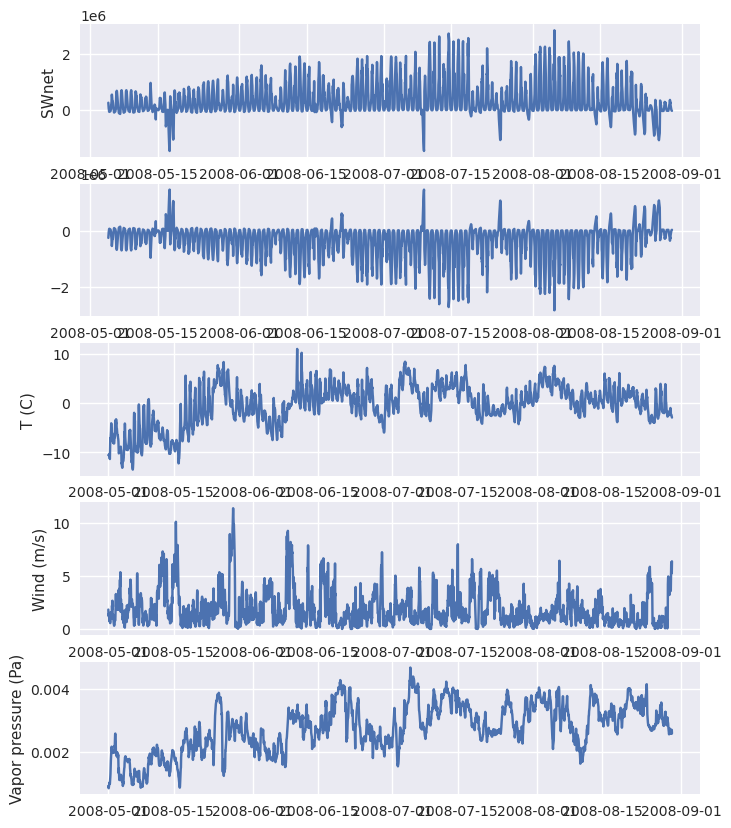

In [23]:
fig,ax = plt.subplots(5,1,figsize=(8,10))
start = pd.to_datetime('2008-05-01 00:00')
end = pd.to_datetime('2008-08-30 00:00')
ds = ds.sel(time=pd.date_range(start,end,freq='h'))
df = df.loc[start:end]
df['SWnet'] = df['SWin']-df['SWout']
sigma_SB = 5.67037e-8
df['LWout'] = (ds.surftemp+273.15)**4*sigma_SB
df['LWin'] = df['NR'] + df['LWout'] - df['SWnet']
ax[0].plot(df.index,df['SWnet'])
ax[0].set_ylabel('SWnet')
ax[1].plot(df.index,df['LWin'])
ax[2].plot(df.index,df['temp'])
ax[2].set_ylabel('T (C)')
ax[3].plot(df.index,df['wind'])
ax[3].set_ylabel('Wind (m/s)')
Ewz = 0.61094*np.exp(17.625*df['temp']/(df['temp']+243.04))*1000
qz = (df['rh']/100)*0.622*(Ewz/(df['sp']-Ewz))
ax[4].plot(df.index,qz)
ax[4].set_ylabel('Vapor pressure (Pa)')
# plt.plot(ds.coords['time'],ds.LWin.sel(bin=1))
# plt.plot(ds.coords['time'],ds.SWin.sel(bin=1)) #-ds.SWout.sel(bin=1)
plt.show()

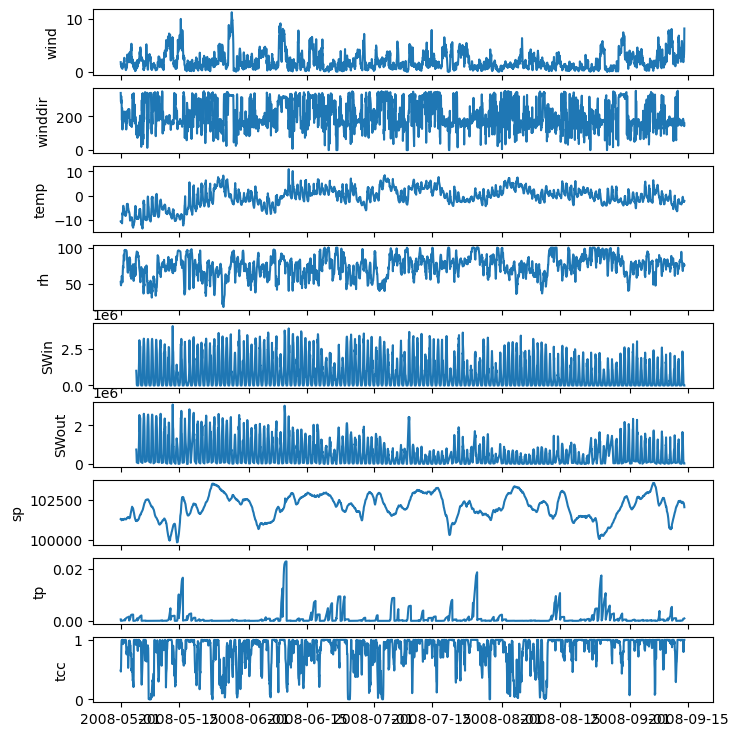

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('~/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008.csv')
df = df.set_index(pd.to_datetime(df['Unnamed: 0']))
df = df.drop(columns=['Unnamed: 0'])
full_vars = []
for var in df.columns:
    if df[var].count() > 0 and var != 'z':
        full_vars.append(var)
n_vars = len(full_vars)
fig,ax = plt.subplots(n_vars,1,sharex = True,figsize=(8,1*n_vars))
# df_plot = df.resample('W').mean()
for i,var in enumerate(full_vars):
    ax[i].plot(df.index,df[var])
    ax[i].set_ylabel(var)
plt.show()

In [19]:
# Fixing SWout in South Glacier data

# df['SWout'] = df['SWout'].mask(df['SWin']<1e-2,0)
# df['SWout'] = df['SWout'].mask(df['SWout']>df['SWin'],df['SWin'])
# print(df[['SWout','SWin']][96:105])
# df.to_csv('~/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008.csv')

                             SWout           SWin
Unnamed: 0                                       
2008-05-05 00:00:00       0.000000       0.000000
2008-05-05 01:00:00       0.000000       0.000000
2008-05-05 02:00:00       0.000000       0.000000
2008-05-05 03:00:00       0.000000       0.000000
2008-05-05 04:00:00       0.000000       0.000000
2008-05-05 05:00:00    1044.000000    1044.000000
2008-05-05 06:00:00   40235.100012   41486.699988
2008-05-05 07:00:00  201890.999988  236724.000012
2008-05-05 08:00:00  672930.000000  853080.000120


In [10]:
import numpy as np
density_ice = 900
density_snow = 200
porosity = (density_ice - density_snow)/density_ice
irrwatercont = 0.0143*np.exp(3.3*porosity)
print(irrwatercont)
irrwatersat = irrwatercont*density_snow/porosity # kg m-3, mass of liquid over pore volume
irrwatercont = irrwatersat*0.2
print(irrwatersat,irrwatercont)


0.18621952206179604
47.88501995874755 9.57700399174951


In [6]:
ds.coords['bin_elev'] = np.array([1546,1693,1854])

In [10]:
temps = np.array([-1.553,-1.781,-1.931,-3.611,-4.385,-4.635,-4.557,-4.189,-3.244,-3.314,-0.126,-2.189,-2.377,-2.376,-2,-1.7,-1.5,-1,-0.8,-.5,-.3,-.2,-.2,0,0,0,0])
depths = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,20,25,30,40,50,60,100,150,200,250,300])
densities = np.interp(depths,ds.coords['layer_depth'],ds.snow_density)
ds = ds.drop_vars(['snow_temp','snow_density'])
ds.coords['layer_depth'] = depths
ds['snow_density'] = xr.DataArray(data=densities,coords={'layer_depth':depths})
ds['snow_temp'] = xr.DataArray(data=temps,coords={'layer_depth':depths})

In [11]:
ds.to_netcdf('~/research/PyGEM-EB/pygem_eb/sample_init_data/01_00570_1.nc')